In [1]:
import open3d as o3d
import numpy as np
import copy
import cv2
import matplotlib.pyplot as plt
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Load the meshes
mesh_name = "000101" # must be 4 digits: xx01 indicates lower jaw, xx02 indicates upper jaw
origin_file_path = f"D:\sunny\Codes\DPS\data_teethseg\origin\{mesh_name}_origin.ply"
label_file_path = f"D:\sunny\Codes\DPS\data_teethseg\label\{mesh_name}.ply"
intraoral_mesh = o3d.io.read_triangle_mesh(origin_file_path)
label_mesh = o3d.io.read_triangle_mesh(label_file_path)

In [3]:
# Recenter the meshes
intraoral_mesh = intraoral_mesh.translate(-intraoral_mesh.get_center())
label_mesh = label_mesh.translate(-label_mesh.get_center())

### 1. Create Circle and Extrude to Cylinders as Projection Screens

In [5]:
# Function to create a circle in the x-z plane
def create_circle(radius, n_points=100):
    theta = np.linspace(0, 2 * np.pi, n_points)
    x = radius * np.cos(theta)
    z = radius * np.sin(theta)
    points = np.vstack((x, np.zeros(n_points), z)).T
    lines = np.column_stack((np.arange(n_points), np.roll(np.arange(n_points), -1)))
    return points, lines

# Function to extrude the circles in the y direction to create cylinders
def extrude_circle(points, extrusion_length_pos, extrusion_length_neg):
    extruded_points = []
    for y in [extrusion_length_neg, extrusion_length_pos]:
        extruded_points.append(points + np.array([0, y, 0]))
    extruded_points = np.vstack(extruded_points)
    
    # Create triangular faces for the extrusion
    n_points = len(points)
    faces = []
    for i in range(n_points):
        next_i = (i + 1) % n_points  # Ensure circular connection
        # Create two triangles for each face of the cylinder
        faces.append([i, next_i, next_i + n_points])
        faces.append([i, next_i + n_points, i + n_points])
    
    return extruded_points, faces

Calculate cylinder parameters based on mesh geometry.<br>
Create cycles and extrude to cylinders for visualization.

In [6]:
# Calculate the radii
distances = np.linalg.norm(np.asarray(intraoral_mesh.vertices)[:, [0, 2]], axis=1)
outer_radius = np.max(distances)
inner_radius = np.min(distances)
n_points = 100

# Calculate the extrusion length
y_min = np.min(np.asarray(intraoral_mesh.vertices)[:, 1])
y_max = np.max(np.asarray(intraoral_mesh.vertices)[:, 1])
extrusion_length_pos = y_max
extrusion_length_neg = y_min
print(f'Extrusion length: {extrusion_length_pos} (pos), {extrusion_length_neg} (neg)')


Extrusion length: 4.702800965296834 (pos), -6.6098101385796015 (neg)


In [7]:
# Create the circles
circle_outer_points, circle_outer_lines = create_circle(outer_radius, n_points)
circle_inner_points, circle_inner_lines = create_circle(inner_radius, n_points)

# Extrude the circles to create cylinders
cylinder_outer_points, cylinder_outer_faces = extrude_circle(circle_outer_points, extrusion_length_pos, extrusion_length_neg)
cylinder_inner_points, cylinder_inner_faces = extrude_circle(circle_inner_points, extrusion_length_pos, extrusion_length_neg)

# Create meshes for the extruded cylinders
cylinder_outer = o3d.geometry.TriangleMesh()
cylinder_outer.vertices = o3d.utility.Vector3dVector(cylinder_outer_points)
cylinder_outer.triangles = o3d.utility.Vector3iVector(cylinder_outer_faces)
cylinder_outer.paint_uniform_color([0.5, 0.5, 1.0])

cylinder_inner = o3d.geometry.TriangleMesh()
cylinder_inner.vertices = o3d.utility.Vector3dVector(cylinder_inner_points)
cylinder_inner.triangles = o3d.utility.Vector3iVector(cylinder_inner_faces)
cylinder_inner.paint_uniform_color([0.5, 1.0, 0.5])

# Create coordinate axes
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10, origin=[0, 0, 0])

# Create grid lines in the xz plane
grid_x = np.linspace(-100, 100, 201)
grid_z = np.linspace(-100, 100, 201)
grid_points = np.array([[x, 0, z] for x in grid_x for z in grid_z])
grid_lines = []
for i, x in enumerate(grid_x):
    grid_lines.append([i * len(grid_z), (i + 1) * len(grid_z) - 1])
for i, z in enumerate(grid_z):
    grid_lines.append([i, len(grid_x) * len(grid_z) - len(grid_x) + i])
grid = o3d.geometry.LineSet(points=o3d.utility.Vector3dVector(grid_points),
                            lines=o3d.utility.Vector2iVector(grid_lines))
grid.paint_uniform_color([0.8, 0.8, 0.8])

# Visualize the splines, curved planes, coordinate axes, and grid
o3d.visualization.draw_geometries([intraoral_mesh, cylinder_outer, cylinder_inner, coordinate_frame, grid])

### 2. Mesh Separation

Separate the mesh into outward- or inward-facing triangular faces

In [ ]:
# # Calculate center coordinate of each triangular faces
# vertices = np.asarray(intraoral_mesh.vertices)
# triangles = np.asarray(intraoral_mesh.triangles)
# face_centers = np.mean(vertices[triangles], axis=1)

# # Calculate normals of each triangular faces
# intraoral_mesh.compute_triangle_normals()
# face_normals = np.asarray(intraoral_mesh.triangle_normals)

# # And classify each face as outward-facing or inward-facing
# outward_face_mask = np.array([np.dot(face_normal, face_center) > 0 for face_normal, face_center in zip(face_normals, face_centers)])
# inward_face_mask = ~outward_face_mask

# # Visualize the separation of the faces
# mesh_in = copy.deepcopy(intraoral_mesh)
# mesh_in.triangles = o3d.utility.Vector3iVector(triangles[inward_face_mask])
# mesh_in.paint_uniform_color([0.5, 0.5, 1.0]) # Blue

# mesh_out = copy.deepcopy(intraoral_mesh)
# mesh_out.triangles = o3d.utility.Vector3iVector(triangles[outward_face_mask])
# mesh_out.paint_uniform_color([0.5, 1.0, 0.5]) # Green

# o3d.visualization.draw_geometries([mesh_in, mesh_out])



In [8]:
# Calculate vertex normals
vertices = np.asarray(intraoral_mesh.vertices)
triangles = np.asarray(intraoral_mesh.triangles)
intraoral_mesh.compute_vertex_normals()
vertex_normals = np.asarray(intraoral_mesh.vertex_normals)
vertex_colors = np.asarray(intraoral_mesh.vertex_colors)

# Classify each vertex as outward-facing or inward-facing
outward_vertex_mask = np.array([np.dot(vertex_normal, vertex) > 0 for vertex_normal, vertex in zip(vertex_normals, vertices)])
inward_vertex_mask = ~outward_vertex_mask

# Convert vertex mask into face mask
outward_face_mask = np.any(outward_vertex_mask[triangles], axis=1)
inward_face_mask = ~outward_face_mask


def clean_io_separation(original_mesh, face_mask_out, face_mask_in, threshold=500):
    """ Preserve only the connected components with number of faces larger than the threshold 
        within each mask. Remove and add the rest components to the opposite mask.
        Return the updated face masks for outward-facing and inward-facing faces"""
    triangles = np.asarray(original_mesh.triangles)
    vertex_colors = np.asarray(original_mesh.vertex_colors)
    
    mesh_in = copy.deepcopy(original_mesh)
    triangles_in = triangles[face_mask_in]
    mesh_in.triangles = o3d.utility.Vector3iVector(triangles_in)
    triangle_clusters_in, cluster_n_triangles_in, _ = (mesh_in.cluster_connected_triangles())
    triangle_clusters_in = np.array(triangle_clusters_in)
    cluster_n_triangles_in = np.array(cluster_n_triangles_in)
    trimask_in_to_out = cluster_n_triangles_in[triangle_clusters_in] < 500 # mask for triangles to be moved to outward-facing
    triangles_in_to_out = triangles_in[trimask_in_to_out]
    triangles_in_reduced = triangles_in[~trimask_in_to_out]

    mesh_out = copy.deepcopy(original_mesh)
    triangles_out = triangles[face_mask_out]
    mesh_out.triangles = o3d.utility.Vector3iVector(triangles_out)
    triangle_clusters_out, cluster_n_triangles_out, _ = (mesh_out.cluster_connected_triangles())
    triangle_clusters_out = np.array(triangle_clusters_out)
    cluster_n_triangles_out = np.array(cluster_n_triangles_out)
    trimask_out_to_in = cluster_n_triangles_out[triangle_clusters_out] < 500 # mask for triangles to be moved to inward-facing
    triangles_out_to_in = triangles_out[trimask_out_to_in]
    triangles_out_reduced = triangles_out[~trimask_out_to_in]

    triangles_in_updated = np.concatenate((triangles_in_reduced, triangles_out_to_in))
    triangles_out_updated = np.concatenate((triangles_out_reduced, triangles_in_to_out))

    mesh_in.triangles = o3d.utility.Vector3iVector(triangles_in_updated)
    mesh_out.triangles = o3d.utility.Vector3iVector(triangles_out_updated)
    
    # Remove unreferenced vertices
    mesh_in.remove_unreferenced_vertices()
    mesh_out.remove_unreferenced_vertices()

    return mesh_in, mesh_out

mesh_in, mesh_out = clean_io_separation(intraoral_mesh, outward_face_mask, inward_face_mask)
label_mesh_in, label_mesh_out = clean_io_separation(label_mesh, outward_face_mask, inward_face_mask)
mesh_in_paint = copy.deepcopy(mesh_in)
mesh_out_paint = copy.deepcopy(mesh_out)
mesh_in_paint.paint_uniform_color([0, 0, 1.0]) # Blue
mesh_out_paint.paint_uniform_color([0, 1.0, 0]) # Green

o3d.visualization.draw_geometries([mesh_in_paint, mesh_out_paint, coordinate_frame, grid])


### 3. Project Original 3D Mesh

In [9]:
# Project vertices onto the respective cylinders
def project_onto_cylinder(vertices, radius):
    projected_vertices = vertices.copy()
    
    for i in range(vertices.shape[0]):
        x, y, z = vertices[i]
        theta = np.arctan2(z, x)
        projected_vertices[i] = [radius * np.cos(theta), y, radius * np.sin(theta)]
    
    # depth in x-z plane relative to the cylinder
    projected_depth = np.linalg.norm(vertices[:, [0, 2]], axis=1) - radius 
    return projected_vertices, projected_depth


def flatten_2d_uv(vertices):
    """ Flatten the projected vertices onto a 2D plane screen"""
    flattened_vertices = []
    for i in range(vertices.shape[0]):
        x, y, z = vertices[i]
        theta = np.arctan2(z, x)
        if theta < -np.pi/2:
            theta += 2 * np.pi
        flattened_vertices.append([theta, y])
    return np.array(flattened_vertices)

def normalize_uv_coordinates(uv_coords, 
                             theta_range=(-np.pi/2, 3*np.pi/2), 
                             y_range_out=(-9, 7), 
                             y_range_in=(-8, 8), 
                             is_outward=True):
    theta_min, theta_max = theta_range
    if is_outward:
        y_min, y_max = y_range_out
    else:
        y_min, y_max = y_range_in
    uv_coords[:, 0] = (uv_coords[:, 0] - theta_min) / (theta_max - theta_min)
    uv_coords[:, 1] = (uv_coords[:, 1] - y_min) / (y_max - y_min)
    return uv_coords



def get_face_colors(triangles, vertex_colors):
    face_colors = []
    for triangle in triangles:
        colors_3vert = vertex_colors[triangle]
        # Get the minimum color value for each channel
        face_color = np.mean(colors_3vert, axis=0) #FIXME: min or mean?
        face_colors.append(face_color)
    return np.array(face_colors)


In [10]:
# Extract the vertices, triangles, vertex colors and face colors
vertices_out = np.asarray(mesh_out.vertices)
triangles_out = np.asarray(mesh_out.triangles)
vertex_colors_out = np.asarray(mesh_out.vertex_colors)
face_colors_out = get_face_colors(triangles_out, vertex_colors_out)
vertex_labels_out = np.asarray(label_mesh_out.vertex_colors)
face_labels_out = get_face_colors(triangles_out, vertex_labels_out)

vertices_in = np.asarray(mesh_in.vertices)
triangles_in = np.asarray(mesh_in.triangles)
vertex_colors_in = np.asarray(mesh_in.vertex_colors)
face_colors_in = get_face_colors(triangles_in, vertex_colors_in)
vertex_labels_in = np.asarray(label_mesh_in.vertex_colors)
face_labels_in = get_face_colors(triangles_in, vertex_labels_in)

# Flip face_labels colors (white (1,1,1) to black (0,0,0), black to white)
face_labels_out = 1 - face_labels_out
face_labels_in = 1 - face_labels_in

# Projection
projected_vertices_out, vert_depth_out = project_onto_cylinder(vertices_out, outer_radius)
projected_vertices_in, vert_depth_in = project_onto_cylinder(vertices_in, inner_radius)

# Flatten the projected vertices onto a 2D plane screen
uv_out = flatten_2d_uv(projected_vertices_out)
uv_in = flatten_2d_uv(projected_vertices_in)

# Normalize the uv coordinates into [0, 1]
uv_norm_out = normalize_uv_coordinates(uv_out, is_outward=True)
uv_norm_in = normalize_uv_coordinates(uv_in, is_outward=False)


In [11]:
px_h = 256 # y axis resolution
px_w = px_h * 8 # theta axis resolution
# Convert uv cooridnates to pixel coordinates, scaling theta to [0,2048) range
uv_pixel_out = np.copy(uv_norm_out)
uv_pixel_out[:, 0] = (uv_pixel_out[:, 0] * px_w-1).astype(np.int32)
uv_pixel_out[:, 1] = (uv_pixel_out[:, 1] * px_h-1).astype(np.int32)

uv_pixel_in = np.copy(uv_norm_in)
uv_pixel_in[:, 0] = (uv_pixel_in[:, 0] * px_w-1).astype(np.int32)
uv_pixel_in[:, 1] = (uv_pixel_in[:, 1] * px_h-1).astype(np.int32)

# FIXME: need to save the uv_pixel_out and uv_pixel_in for each mesh!!!!!!!!!

# Calculate mean projection depth for each face
face_depth_out = np.mean(vert_depth_out[triangles_out], axis=1)
face_depth_in = np.mean(vert_depth_in[triangles_in], axis=1)

# Sort the faces by depth (ascending)
sorted_indices_out = np.argsort(face_depth_out)
sorted_triangles_out = triangles_out[sorted_indices_out]
sorted_face_colors_out = face_colors_out[sorted_indices_out]
sorted_face_colors_out = (sorted_face_colors_out * 255).astype(np.uint8)
sorted_face_labels_out = face_labels_out[sorted_indices_out]
sorted_face_labels_out = (sorted_face_labels_out * 255).astype(np.uint8)


sorted_indices_in = np.argsort(face_depth_in)
sorted_triangles_in = triangles_in[sorted_indices_in]
sorted_face_colors_in = face_colors_in[sorted_indices_in]
sorted_face_colors_in = (sorted_face_colors_in * 255).astype(np.uint8)
sorted_face_labels_in = face_labels_in[sorted_indices_in]
sorted_face_labels_in = (sorted_face_labels_in * 255).astype(np.uint8)

# Initialize the large 2D image (1024x8192) for the entire dataset
entire_origin_image_out = np.zeros((px_h, px_w, 3), dtype=np.uint8)
entire_origin_image_in = np.zeros((px_h, px_w, 3), dtype=np.uint8)
entire_label_image_out = np.zeros((px_h, px_w, 3), dtype=np.uint8)
entire_label_image_in = np.zeros((px_h, px_w, 3), dtype=np.uint8)



# Rasterize the triangles onto the large image
# Crop the large image into 8 sections, each with size 1024x1024x3
def rasterize(sorted_triangles, sorted_face_colors, uv_pixel, large_image):
    """ Return section_images as numpy arrays, with shape (8, 1024, 1024, 3)"""
    for i, triangle in enumerate(sorted_triangles):
        pts = uv_pixel[triangle].reshape((-1, 1, 2)).astype(np.int32)
        face_color = tuple(int(c) for c in sorted_face_colors[i])  # Convert to tuple for cv2.fillPoly
        cv2.fillPoly(large_image, [pts], face_color)

    section_images = np.array([large_image[:, i*px_h:(i+1)*px_h] for i in range(8)])
    return section_images, large_image

origin_images_out, entire_origin_image_out = rasterize(sorted_triangles_out, sorted_face_colors_out, uv_pixel_out, entire_origin_image_out)
origin_images_in, entire_origin_image_in = rasterize(sorted_triangles_in, sorted_face_colors_in, uv_pixel_in, entire_origin_image_in)
origin_images = np.array([origin_images_out, origin_images_in])
# flatten into (16, 256, 256, 3)
origin_images = origin_images.reshape(-1, px_h, px_h, 3)

label_images_out, entire_label_image_out = rasterize(sorted_triangles_out, sorted_face_labels_out, uv_pixel_out, entire_label_image_out)
label_images_in, entire_label_image_in = rasterize(sorted_triangles_in, sorted_face_labels_in, uv_pixel_in, entire_label_image_in)
label_images = np.array([label_images_out, label_images_in])
# flatten into (16, 256, 256, 3)
label_images = label_images.reshape(-1, px_h, px_h, 3)

save_dir = "D:\sunny\Codes\DPS\data_npy2d"

In [12]:
print(origin_images.shape)
print(label_images.shape) # color values are 0 to 255

(16, 256, 256, 3)
(16, 256, 256, 3)


In [13]:
# Convert label_images into binary masks (0 or 1)
# set pixels with any non-zero rgb values to 1
# else if pixel has color (0,0,0) set to 0
def convert_to_binary(label_images):
    binary_images = np.any(label_images != 0, axis=-1).astype(np.uint8)
    return binary_images

label_images_binary = convert_to_binary(label_images)
print(label_images_binary.shape)


(16, 256, 256)


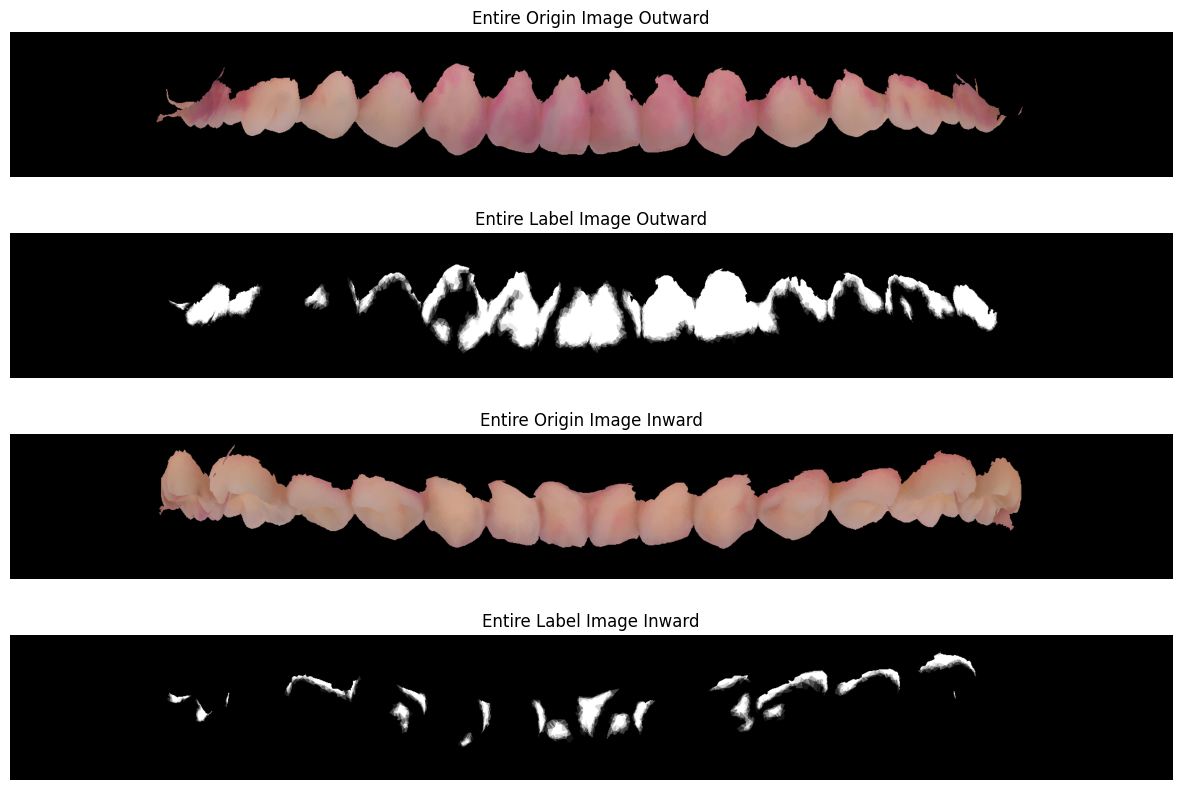

In [14]:
# Display the large image for visualization
fig, ax = plt.subplots(4,1, figsize=(15, 10))

ax[0].imshow(entire_origin_image_out)
ax[0].set_title("Entire Origin Image Outward")
ax[0].axis('off')


ax[1].imshow(entire_label_image_out)
ax[1].set_title("Entire Label Image Outward")
ax[1].axis('off')

ax[2].imshow(entire_origin_image_in)
ax[2].set_title("Entire Origin Image Inward")
ax[2].axis('off')

ax[3].imshow(entire_label_image_in)
ax[3].set_title("Entire Label Image Inward")
ax[3].axis('off')

# plt.savefig(os.path.join(save_dir, "jpg", f"{mesh_name}.jpg"))

plt.show()

In [ ]:

# save_origin_path = os.path.join(save_dir, "origin", f'{mesh_name}.npy')
# save_label_path = os.path.join(save_dir, "label", f'{mesh_name}.npy')

# # Save the section images as a single npy file
# np.save(save_origin_path, origin_images)
# np.save(save_label_path, label_images_binary)


In [ ]:
# tensor_origin = np.load(save_origin_path)
# tensor_label = np.load(save_label_path)
# origin_image_test = tensor_origin[4, :, :, :]
# label_image_test = tensor_label[4, :, :]

# fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# ax[0].imshow(origin_image_test)
# ax[0].axis("off")
# ax[1].imshow(label_image_test)
# ax[1].axis("off")
# plt.show()

In [ ]:
# # convert rgb to bgr
# origin_image_test = cv2.cvtColor(origin_image_test, cv2.COLOR_RGB2BGR)
# label_image_test = cv2.cvtColor(label_image_test, cv2.COLOR_RGB2BGR)

# # save origin_image_test and label_image_test as jpg
# cv2.imwrite(os.path.join(save_dir, "jpg", f"{mesh_name}_origin_image_test.jpg"), origin_image_test)
# cv2.imwrite(os.path.join(save_dir, "jpg", f"{mesh_name}_label_image_test.jpg"), label_image_test)



### Map back to 3D

In [ ]:
print(np.unique(label_mesh_in.vertex_colors))

In [15]:

# FIXME:!!!!!!
# In contrast, GT: vertex_labels_out, vertex_labels_in are not flipped, RGB (0-1)

# Assuming the predicted label images has been converted from binary masks to RGB images (0-255)
# intensity flipped (1 to 0, 0 to 1)
predicted_label_images = label_images  # Directly load the GT label images as the predicted label images (ideal case test)

# Reshape the predicted label images into the original 8x1024x1024 format from the 16x256x256 format
print(predicted_label_images.shape)
predicted_label_images = predicted_label_images.reshape(2, 8, px_h, px_h, 3)
# Divide by 255 to convert back to [0, 1] range and flip the intensity (1 to 0, 0 to 1)
predicted_label_images = 1 - predicted_label_images / 255


def determine_pred_labels_for_uv(uv_pixel_in, uv_pixel_out, predicted_label_images):
    """ Assign labels to points based on predicted label images """
    # Initialize arrays to store the labels of each point or triangle
    vertex_pred_labels_out = np.zeros((uv_pixel_out.shape[0], 3), dtype=np.int8)
    vertex_pred_labels_in = np.zeros((uv_pixel_in.shape[0], 3), dtype=np.int8)
    
    for i, (u, v) in enumerate(uv_pixel_out):
        section = int(u // px_h) # Determine the section of the point
        local_u = int(u % px_h) # Determine the local u coordinate within the section
        v = np.clip(int(v), 0, 255) # Ensure the v coordinate is within the range
        vertex_pred_labels_out[i] = predicted_label_images[0, section, v, local_u] # 0 for outward-facing

    for i, (u, v) in enumerate(uv_pixel_in):
        section = int(u // px_h) # Determine the section of the point
        local_u = int(u % px_h) # Determine the local u coordinate within the section
        v = np.clip(int(v), 0, 255) # Ensure the v coordinate is within the range
        vertex_pred_labels_in[i] = predicted_label_images[1, section, v, local_u] # 1 for inward-facing
    return vertex_pred_labels_out, vertex_pred_labels_in


# Determine the labels for the points in 'out' and 'in' UV coordinates
vertex_pred_labels_out, vertex_pred_labels_in = determine_pred_labels_for_uv(uv_pixel_in, uv_pixel_out, predicted_label_images)

# # For each triangle, determine the label by majority voting (or another method) based on its vertices' labels
# face_pred_labels_out = np.array([np.argmax(np.bincount(vertex_pred_labels_out[triangle])) for triangle in sorted_triangles_out])
# face_pred_labels_in = np.array([np.argmax(np.bincount(vertex_pred_labels_in[triangle])) for triangle in sorted_triangles_in])

# Now, triangle_labels_out and triangle_labels_in contain the labels for each triangle based on the predicted label images
# FIXME: Compare the predicted labels with the ground truth labels to evaluate the model
# FIXME: point_labels vs vertex_labels (GT); triangle_labels vs face_labels (GT) --> compute IoU, Dice, etc. metrics

print(vertex_labels_out.shape)
print(type(vertex_labels_out[0,0]))
print(vertex_labels_out[0,0])
print(vertex_pred_labels_out.shape)
print(type(vertex_pred_labels_out[0,0]))
print(vertex_pred_labels_out[0,0])

# Compute the IoU and Dice scores for the vertices
def compute_metrics(gt_labels, pred_labels):
    """ Compute the IoU and Dice scores for the outward-facing faces """
    intersection = np.sum(np.logical_and(gt_labels, pred_labels))
    union = np.sum(np.logical_or(gt_labels, pred_labels))
    iou = intersection / union
    dice = 2 * intersection / (np.sum(gt_labels) + np.sum(pred_labels))
    return iou, dice

iou_out, dice_out = compute_metrics(vertex_labels_out, vertex_pred_labels_out)
iou_in, dice_in = compute_metrics(vertex_labels_in, vertex_pred_labels_in)

print(f"IoU (outward): {iou_out:.4f}, Dice (outward): {dice_out:.4f}")
print(f"IoU (inward): {iou_in:.4f}, Dice (inward): {dice_in:.4f}")

(16, 256, 256, 3)
(10499, 3)
<class 'numpy.float64'>
1.0
(10499, 3)
<class 'numpy.int8'>
1
IoU (outward): 0.7046, Dice (outward): 0.8464
IoU (inward): 0.9315, Dice (inward): 0.9717


In [16]:
# visualize the predicted label images in mesh form
def visualize_pred_labels(GTlabel_mesh, vertex_pred_labels): # assume vertex_pred_labels is in RGB format (0-1) non-binary
    """ Visualize the predicted labels on the mesh """
    mesh_pred = copy.deepcopy(GTlabel_mesh)
    vertices = np.asarray(mesh_pred.vertices)
    triangles = np.asarray(mesh_pred.triangles)
    colors = np.asarray(mesh_pred.vertex_colors).astype(np.int8)



    for i in range(len(vertices)):
       if not np.array_equal(vertex_pred_labels[i], np.array([1, 1, 1])):  # Check if predicted label is not white
            if np.array_equal(colors[i], np.array([1, 1, 1])):  # False positive
                colors[i] = np.array([1, 0, 0]) # Red
            else: # True positive
                colors[i] = np.array([0, 1, 0]) # Green
        
    mesh_pred.vertex_colors = o3d.utility.Vector3dVector(colors)

    return mesh_pred

In [17]:
mesh_pred_out = visualize_pred_labels(label_mesh_out, vertex_pred_labels_out)
mesh_pred_in = visualize_pred_labels(label_mesh_in, vertex_pred_labels_in)

# set scene background to grey
# o3d.visualization.draw_geometries([mesh_pred_out, mesh_pred_in, coordinate_frame, grid])

# Visualize the meshes with a grey background
def custom_draw_geometry_with_background(geometry_list, window_name="Open3D"):
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name=window_name)
    for geometry in geometry_list:
        vis.add_geometry(geometry)
    opt = vis.get_render_option()
    opt.background_color = np.asarray([0.5, 0.5, 0.5])
    vis.run()
    vis.destroy_window()

custom_draw_geometry_with_background([mesh_pred_out, mesh_pred_in, coordinate_frame], window_name="Predicted Labels")
